In [34]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 

In [2]:
# FOR REPRODUCIBILITY
np.random.seed(7)


In [17]:
#Read the csv file
df = pd.read_csv('.csv files/nepse_NICA.csv')
df = df[::-1]
df = df.reset_index()
df.head()



,index,Symbol,Date,Open,Close,Volume,High,Low
0,2187,NICA,2/27/2023,810.0,812.0,62896,820.0,801.1
1,2186,NICA,2/26/2023,810.1,810.0,98067,815.0,793.8
2,2185,NICA,2/23/2023,808.0,814.0,98136,815.0,803.4
3,2184,NICA,2/22/2023,821.0,818.0,55398,821.0,808.0
4,2183,NICA,2/20/2023,809.0,815.0,68598,819.9,798.0


<Axes: >

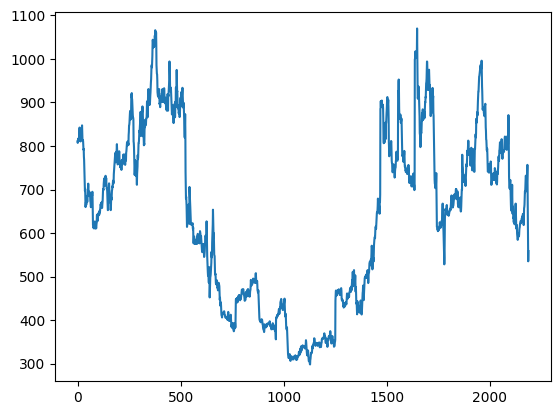

In [20]:
#OHLC IN SINGLE COLUMN BY TAKING THEIR AVERAGE
OHLC_avg = df[['Close', 'Open', 'High', 'Low']].mean(axis = 1)

OHLC_avg.plot()

In [21]:
#scaling of data
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

<Axes: >

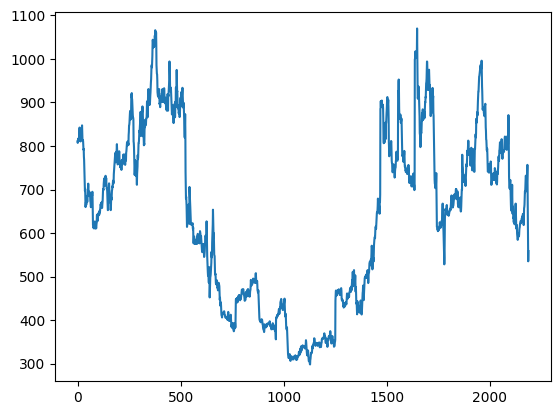

In [11]:
OHLC_avg = df[['Close', 'Open', 'High', 'Low']].mean(axis = 1)

OHLC_avg.plot()

In [25]:
#scaling the dataset
OHLC_avg = np.reshape(OHLC_avg, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)


In [28]:
#split into train-test
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]


In [38]:
#previous day data is used to predict the next day data
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [39]:
#reset the data as feasible for input in lstm model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [45]:
#define autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1, 64)             16896     
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compile to make predictions
# fit the model
history = model.fit(trainX, testX, epochs=100, batch_size=64, validation_split=0.1, verbose=1)


In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

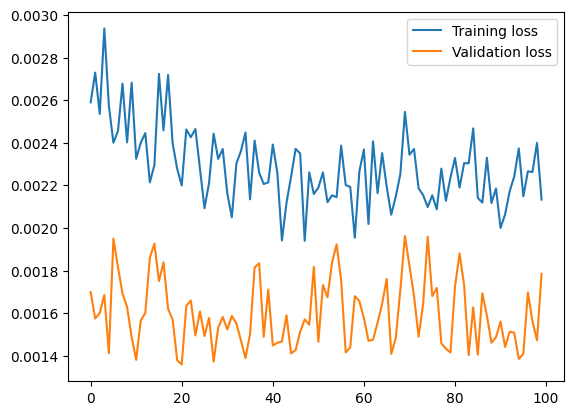

In [51]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [52]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [53]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 0.02
Test RMSE: 0.03


In [54]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict


In [55]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict


In [56]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)


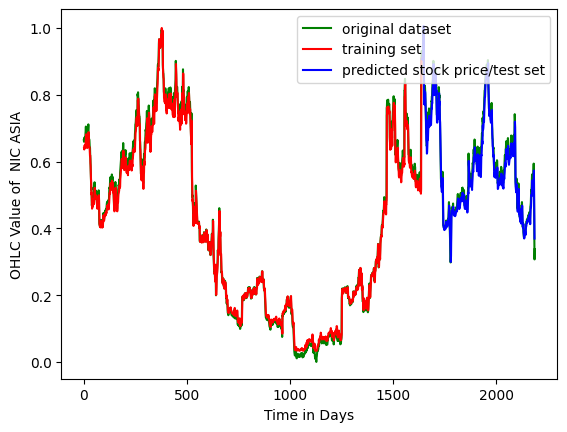

In [57]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of  NIC ASIA')
plt.show()

Epoch 1/5
2186/2186 - 10s - loss: 0.0088 - 10s/epoch - 4ms/step
Epoch 2/5
2186/2186 - 5s - loss: 5.1231e-04 - 5s/epoch - 2ms/step
Epoch 3/5
2186/2186 - 5s - loss: 4.7154e-04 - 5s/epoch - 2ms/step
Epoch 4/5
2186/2186 - 5s - loss: 5.0317e-04 - 5s/epoch - 2ms/step
Epoch 5/5
2186/2186 - 5s - loss: 5.0203e-04 - 5s/epoch - 2ms/step
1/1 [==============================] - 1s 1s/step
Epoch 1/5
2187/2187 - 5s - loss: 4.9138e-04 - 5s/epoch - 2ms/step
Epoch 2/5
2187/2187 - 5s - loss: 4.8857e-04 - 5s/epoch - 2ms/step
Epoch 3/5
2187/2187 - 5s - loss: 4.8962e-04 - 5s/epoch - 2ms/step
Epoch 4/5
2187/2187 - 5s - loss: 4.9100e-04 - 5s/epoch - 2ms/step
Epoch 5/5
2187/2187 - 5s - loss: 4.7301e-04 - 5s/epoch - 2ms/step
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
2188/2188 - 5s - loss: 4.6765e-04 - 5s/epoch - 2ms/step
Epoch 2/5
2188/2188 - 5s - loss: 4.6844e-04 - 5s/epoch - 2ms/step
Epoch 3/5
2188/2188 - 5s - loss: 4.7264e-04 - 5s/epoch - 2ms/step
Epoch 4/5
2188/2188 - 5s - loss: 4.6688e-0

Epoch 4/5
2207/2207 - 5s - loss: 4.1758e-04 - 5s/epoch - 2ms/step
Epoch 5/5
2207/2207 - 5s - loss: 4.0496e-04 - 5s/epoch - 2ms/step
1/1 [==============================] - 0s 31ms/step
Epoch 1/5
2208/2208 - 5s - loss: 4.0415e-04 - 5s/epoch - 2ms/step
Epoch 2/5
2208/2208 - 5s - loss: 4.0741e-04 - 5s/epoch - 2ms/step
Epoch 3/5
2208/2208 - 5s - loss: 4.0311e-04 - 5s/epoch - 2ms/step
Epoch 4/5
2208/2208 - 5s - loss: 4.1265e-04 - 5s/epoch - 2ms/step
Epoch 5/5
2208/2208 - 5s - loss: 4.0399e-04 - 5s/epoch - 2ms/step
1/1 [==============================] - 0s 31ms/step
Epoch 1/5
2209/2209 - 5s - loss: 4.0530e-04 - 5s/epoch - 2ms/step
Epoch 2/5
2209/2209 - 5s - loss: 4.1433e-04 - 5s/epoch - 2ms/step
Epoch 3/5
2209/2209 - 5s - loss: 4.1093e-04 - 5s/epoch - 2ms/step
Epoch 4/5
2209/2209 - 5s - loss: 4.0198e-04 - 5s/epoch - 2ms/step
Epoch 5/5
2209/2209 - 5s - loss: 4.0863e-04 - 5s/epoch - 2ms/step
1/1 [==============================] - 0s 31ms/step
Epoch 1/5
2210/2210 - 5s - loss: 4.1304e-04 - 5s/epo

In [ ]:
# Inverse transform the last value of testPredict
last_val = scaler.inverse_transform(testPredict[-1].reshape(-1, 1))

# Scale the last value using the scaler object
last_val_scaled = scaler.transform(last_val.reshape(-1, 1))

# Predict the next value and inverse transform it
next_val_scaled = model.predict(np.reshape(last_val_scaled, (1, 1, 1)))
next_val = scaler.inverse_transform(next_val_scaled.reshape(-1, 1))

print("Last Day Value:", last_val[0][0])
print("Next Day Value:", next_val[0][0])


In [ ]:
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))


In [ ]:
import matplotlib.pyplot as plt

# Get the original time series data
original_data = scaler.inverse_transform(OHLC_avg)

# Get the predicted values for the test set
predicted_data = scaler.inverse_transform(testPredict)

# Create a plot
plt.figure(figsize=(16,8))
plt.plot(original_data, label='Original Data')
plt.plot(range(train_OHLC, train_OHLC + len(predicted_data)), predicted_data, label='Predicted Data')
plt.xlabel('Time')
plt.ylabel('OHLC Average')
plt.title('Original Data vs Predicted Data')
plt.legend()
plt.show()
